Plot the overapproximating polytopes from the predictions.

In [1]:
%matplotlib inline
import sys
import os
import json
from glob import glob

import numpy as np
import torch
import dill
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import matplotlib.animation as animation

PYTHONAPI_EGG_PATH = f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg"
sys.path.append('..')
sys.path.append('../../../trajectron')
sys.path.append('../../../..')
sys.path.append(PYTHONAPI_EGG_PATH)

import utility as util
import carlautil
from helper import load_model, prediction_output_to_trajectories
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

from utils.trajectory_utils import prediction_output_to_trajectories

from model.components.discrete_latent import DiscreteLatent

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'olive', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 3) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

Search for CARLA datasets

In [2]:
search_datasets = False
dataset_dir = '../../../..'
glob(f"{ dataset_dir }/**/*.pkl") if search_datasets else []

[]

In [3]:
dataset_0 = util.AttrDict(
    test_set_path='../processed/nuScenes_test_full.pkl',
    desc="NuScenes test set")

dataset_1 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
    desc="CARLA synthesized dataset with bitmap mis-matched from NuScenes",
    v2_bitmap=True)

dataset_2 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
    desc="CARLA synthesized dataset")

dataset_3 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
    desc="CARLA synthesized dataset smaller sized")

dataset_4 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3_0_1_dataset/carla_test_v3_0_1_full.pkl",
        name='carla_train_v3_0_1',
        desc="CARLA synthesized dataset smaller sized with heading fix",
        v2_bitmap=True)
    
dataset_5 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1_dataset/v3-1_split1_test.pkl",
        name='v3-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset = dataset_5
with open(dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(dataset.desc)

CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.


Load NuScenes dataset

Search models

In [4]:
search_models = False
[x[0] for x in os.walk('../models')] if search_models else None

Load model

In [5]:
model_1 = util.AttrDict(
        path='models/20210622/models_20_Jun_2021_23_53_04_carla_v2_1_dynmap',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on carla v2_1 dataset)")

model_2 = util.AttrDict(
        path='models/20210603/models_06_Jun_2021_17_02_01_carla_v2_K12',
        desc="Base model +Dynamics Integration, Maps with K=12 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_3 = util.AttrDict(
        path='models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on NuScenes dataset)")

model_4 = util.AttrDict(
        path='models/20210713/models_03_Jul_2021_23_44_36_carla_v2_1_dynmap_K6',
        desc="Base model +Dynamics Integration, Maps with K=6 latent values "
             "(on carla v2_1 dataset)")

model_5 = util.AttrDict(
        path='models/20210610/models_16_Jun_2021_20_33_57_carla_v2_base_ph6',
        desc="Base model with K=25 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_9 = util.AttrDict(
        path='models/models_19_Jul_2021_21_09_20_carla_v3_0_1_base_dist_ph6',
        desc="Base model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_10 = util.AttrDict(
        path='models/models_20_Jul_2021_03_51_57_carla_v3_0_1_base_distmap_ph6',
        desc="Base +Map model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_11 = util.AttrDict(
        path='../models/models_20_Jul_2021_11_48_11_carla_v3_0_1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8 "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_12 = util.AttrDict(
        path='../models/20210804/models_25_Jul_2021_15_29_29_carla_v3-1_base_distmap_ph8',
        desc="Base +Map model with heading and occlusion fix, PH=8 "
             "(trained on small carla v3-1 dataset)")

model = model_12
eval_stg, hyp = load_model(model.path, eval_env, ts=20)#, device='cuda')
print(model.desc)


Loading from ../models/20210804/models_25_Jul_2021_15_29_29_carla_v3-1_base_distmap_ph8/model_registrar-20.pt
Loaded!

Base +Map model with heading and occlusion fix, PH=8 (trained on small carla v3-1 dataset)


### Combining forecast and map

In [6]:
def render_roads(ax, scene, is_white=False):
    road_color = 'white' if is_white else 'grey'
    map_mask = scene.map['VEHICLE'].as_image()
    # map_mask has shape (y, x, c)
    road_bitmap = np.max(map_mask, axis=2)
    road_div_bitmap = map_mask[..., 1]
    lane_div_bitmap = map_mask[..., 0]

    # extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
    extent = (0, scene.x_size, 0, scene.y_size)

    if 'v2_bitmap' in model:
        if 'v2_bitmap' not in dataset:
            print('WARNING: dataset not v2')
        # map_mask has shape (y, x, c)
        road_bitmap = np.max(map_mask, axis=2)
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 0]

        # Axes.imshow() expects (y, x, c)
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))
    else:
        if 'v2_bitmap' in dataset:
            print('WARNING: dataset is v2')
        """
        NuScenes bitmap format
        scene.map[...].as_image() has shape (y, x, c)
        Channel 1: lane, road_segment, drivable_area
        Channel 2: road_divider
        Channel 3: lane_divider
        """
        # NuScenes
        road_bitmap = np.max(map_mask, axis=2)
        road_bitmap = map_mask[..., 0]
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 2]
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

In [7]:
# good example of stopped vehicles for v3_0_1
# scene = eval_scenes[5] 
# scene = eval_scenes[9]
# roundabout for v3_0_1
# scene = eval_scenes[26]

# intersection with lots of stuff happening for v3_0_1
scene = eval_scenes[13]

# scene = eval_scenes[4]

ph = 8
num_samples = 100
timestep = 22
timesteps = np.array([timestep])

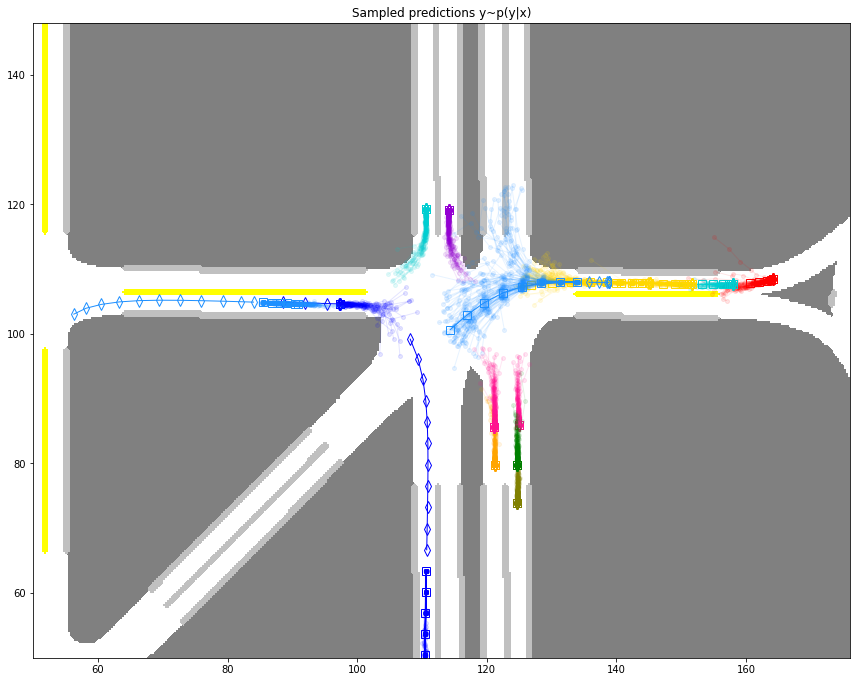

In [8]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))

fig, ax = plt.subplots(figsize=(12,15))
render_roads(ax, scene, is_white=True)

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[timestep][node]
    player_past = histories_dict[timestep][node]
    player_predict = prediction_dict[timestep][node]

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

ax.set_title("Sampled predictions y~p(y|x)")
ax.set_aspect('equal')
ax.set_facecolor("grey")
        
extent = np.array([0, scene.x_size, 0, scene.y_size])
should_zoom_in = True
if should_zoom_in:
    zoom = np.array([50, 50])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
fig.tight_layout()
None

## Outer Approximations

Compute the vertices and outer approximations from predictions

In [9]:
def generate_vehicle_latents(
            eval_stg, scene, timesteps,
            num_samples = 200, ph = 8,
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(
            mode=mode, inputs=inputs, inputs_st=inputs_st,
            labels=None, labels_st=None, first_history_indices=first_history_indices,
            neighbors=neighbors, neighbors_edge_value=neighbors_edge_value,
            robot=robot, map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    latent_probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    latent_probs = np.squeeze(latent_probs)

    z, num_samples, num_components = model.latent.sample_p(
            num_samples, mode, most_likely_z=z_mode,
            full_dist=full_dist, all_z_sep=all_z_sep)
    
    _, predictions = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
            prediction_horizon, num_samples, num_components, gmm_mode)

    z = z.cpu().detach().numpy()
    # z has shape (number of samples, number of vehicles, number of latent values)
    # z[i,j] gives the latent for sample i of vehicle j
    # print(z.shape)
    
    predictions = predictions.cpu().detach().numpy()
    # predictions has shape (number of samples, number of vehicles, prediction horizon, D)
    # print(predictions.shape)

    predictions_dict = dict()
    for i, ts in enumerate(timesteps_o):
        if ts not in predictions_dict.keys():
            predictions_dict[ts] = dict()
        predictions_dict[ts][nodes[i]] = np.transpose(predictions[:, [i]], (1, 0, 2, 3))
    
    z = np.swapaxes(np.argmax(z, axis=-1), 0, 1)
    predictions = np.swapaxes(predictions, 0, 1)
    return z, predictions, nodes, predictions_dict, latent_probs

class OVehicle(object):

    @classmethod
    def from_trajectron(cls, node, T, ground_truth, past,
            latent_pmf, predictions, filter_pmf=0.1, bbox=[4.5, 2.5]):
        """Create other vehicle from Trajectron++ prediction.

        Parameters
        ==========
        ground_truth : np.array
            Array of ground truth trajectories of shape (T_gt_v, 2)
            T_gt_v is variable
        past : np.array
            Array of past trajectories of shape (T_past_v, 2)
            T_past_v is variable
        latent_pmf : np.array
            Array of past trajectories of shape (latent_states)
            Default settings in Trajectron++ sets latent_states to 25
        predictions : list of np.array
            List of predictions indexed by latent value.
            Each set of prediction corresponding to a latent is size (number of preds, T_v, 2)
        filter_pmf : float
            Filter value to apply on PMF. All predictions p(y|x,z) with PMF p(z) >= filter_pmf
            are placed in cluster z. Thre rest of the predictions are sorted to the cluster
            closest to an existing cluster.
        bbox : list of float
            Vehicle bounding box of form [longitudinal axis, lateral axis] in meters.
        """
        n_states = len(predictions)
        n_predictions = sum([p.shape[0] for p in predictions])
        
        """Heejin's control code"""
        pos_last = past[-1]
        # Masking to get relevant predictions.
        latent_mask = np.argwhere(latent_pmf > filter_pmf).ravel()
        masked_n_predictions = 0
        masked_n_states = latent_mask.size
        masked_pred_positions = []
        masked_pred_yaws = []
        masked_init_center = np.zeros((masked_n_states, 2))

        for latent_idx, latent_val in enumerate(latent_mask):
            """Preprocess the predictions that correspond to the latents in the mask"""
            ps = predictions[latent_val]
            n_p = ps.shape[0]
            yaws = np.zeros((n_p, T))
            # diff = (ps[:,0,1] - pos_last[1])**2  - ( ps[:,0,0] - pos_last[0])**2
            # TODO: skipping the i_keep_yaw code
            yaws[:,0] = np.arctan2(ps[:,0,1] - pos_last[1], ps[:,0,0] - pos_last[0])
            for t in range(1, T):
                # diff = (ps[:,t,1] - ps[:,t-1,1])**2  - (ps[:,t,0] - ps[:,t-1,0])**2
                # TODO: skipping the i_keep_yaw code
                yaws[:,t] = np.arctan2(ps[:,t,1] - ps[:,t-1,1], ps[:,t,0] - ps[:,t-1,0])
            masked_pred_positions.append(ps)
            masked_pred_yaws.append(yaws)
            masked_n_predictions += n_p
            masked_init_center[latent_idx] = np.mean(ps[:, T-1], axis=0)
        latent_neg_mask = np.in1d(np.arange(n_states), latent_mask, invert=True)
        latent_neg_mask = np.arange(n_states)[latent_neg_mask]
        for latent_val in latent_neg_mask:
            """Group rare latent values to the closest common latent variable"""
            ps = predictions[latent_val]
            if ps.size == 0:
                continue
            n_p = ps.shape[0]
            yaws = np.zeros((n_p, T))
            # TODO: skipping the i_keep_yaw code
            yaws[:,0] = np.arctan2(ps[:,0,1] - pos_last[1], ps[:,0,0] - pos_last[0])
            for t in range(1, T):
                # TODO: skipping the i_keep_yaw code
                yaws[:,t] = np.arctan2(ps[:,t,1] - ps[:,t-1,1], ps[:,t,0] - ps[:,t-1,0])
            
            dist = scipy.spatial.distance_matrix(ps[:,T-1,:], masked_init_center)
            p_cluster_ids = np.argmin(dist, axis=1)
            for idx in range(masked_n_states):
                tmp_ps = ps[p_cluster_ids == idx]
                if tmp_ps.size == 0:
                    continue
                tmp_yaws = yaws[p_cluster_ids == idx]
                masked_pred_positions[idx] = np.concatenate(
                        (masked_pred_positions[idx], tmp_ps,))
                masked_pred_yaws[idx] = np.concatenate(
                        (masked_pred_yaws[idx], tmp_yaws,))
            masked_n_predictions += n_p

        masked_latent_pmf = np.zeros(latent_mask.shape)
        for idx in range(masked_n_states):
            """Recreate the PMF"""
            n_p = masked_pred_positions[idx].shape[0]
            masked_latent_pmf[idx] = n_p / float(masked_n_predictions)
        
        return cls(node, T, past, ground_truth, masked_latent_pmf,
                masked_pred_positions, masked_pred_yaws, masked_init_center,
                bbox)

    def __init__(self, node, T, past, ground_truth, latent_pmf,
            pred_positions, pred_yaws, init_center, bbox):
        self.node = node
        self.T = T
        self.past = past
        self.ground_truth = ground_truth
        self.latent_pmf = latent_pmf
        self.pred_positions = pred_positions
        self.pred_yaws = pred_yaws
        self.init_center = init_center
        self.bbox = bbox
        self.n_states = self.latent_pmf.size
        self.n_predictions = sum([p.shape[0] for p in self.pred_positions])

def get_vertices_from_centers(centers, headings, lw):
    """Like get_vertices_from_center() but broadcasted
    over multiple centers and headings.
    """
    C = np.cos(headings)
    S = np.sin(headings)
    rot11 = np.stack(( C,  S), axis=-1)
    rot12 = np.stack(( S, -C), axis=-1)
    rot21 = np.stack(( C, -S), axis=-1) 
    rot22 = np.stack(( S,  C), axis=-1)
    rot31 = np.stack((-C, -S), axis=-1)
    rot32 = np.stack((-S,  C), axis=-1)
    rot41 = np.stack((-C,  S), axis=-1)
    rot42 = np.stack((-S, -C), axis=-1)
    # Rot has shape (1000, 8, 2)
    Rot = np.stack((rot11, rot12, rot21, rot22, rot31, rot32, rot41, rot42), axis=1)
    # disp has shape (1000, 8)
    disp = 0.5 * Rot @ lw
    # centers has shape (1000, 8)
    centers = np.tile(centers, (4,))
    return centers + disp

def get_approx_union(theta, vertices):
    """Gets A_t, b_0 for the contraint set A_t x >= b_0
    vertices : np.array
        Vertices of shape (?, 8)
    
    Returns
    =======
    np.array
        A_t matrix of shape (4, 2)
    np.array
        b_0 vector of shape (4,)
    """
    At = np.array([
            [ np.cos(theta), np.sin(theta)],
            [-np.sin(theta), np.cos(theta)]])
    At = np.concatenate((np.eye(2), -np.eye(2),)) @ At

    a0 = np.max(At @ vertices[:, 0:2].T, axis=1)
    a1 = np.max(At @ vertices[:, 2:4].T, axis=1)
    a2 = np.max(At @ vertices[:, 4:6].T, axis=1)
    a3 = np.max(At @ vertices[:, 6:8].T, axis=1)
    b0 = np.max(np.stack((a0, a1, a2, a3)), axis=0)
    return At, b0

def compute_vertices(params, ovehicles):
    """Compute verticles from predictions."""
    T, K, n_ov = ph, params.K, params.O
    vertices = np.empty((T, np.max(K), n_ov), dtype=object).tolist()
    for ov_idx, ovehicle in enumerate(ovehicles):
        for latent_idx in range(ovehicle.n_states):
            for t in range(T):
                ps = ovehicle.pred_positions[latent_idx][:,t]
                yaws = ovehicle.pred_yaws[latent_idx][:,t]
                vertices[t][latent_idx][ov_idx] = get_vertices_from_centers(
                        ps, yaws, ovehicle.bbox) 
    return vertices

def compute_overapproximations(vertices, params, ovehicles):
    """Compute the approximation of the union of obstacle sets"""
    T, K, n_ov = ph, params.K, params.O
    A_union = np.empty((T, np.max(K), n_ov,), dtype=object).tolist()
    b_union = np.empty((T, np.max(K), n_ov,), dtype=object).tolist()
    for ov_idx, ovehicle in enumerate(ovehicles):
        for latent_idx in range(ovehicle.n_states):
            for t in range(T):
                yaws = ovehicle.pred_yaws[latent_idx][:,t]
                vertices_k = vertices[t][latent_idx][ov_idx]
                mean_theta_k = np.mean(yaws)
                A_union_k, b_union_k = get_approx_union(mean_theta_k, vertices_k)
                A_union[t][latent_idx][ov_idx] = A_union_k
                b_union[t][latent_idx][ov_idx] = b_union_k
    return A_union, b_union

def plot_h_polyhedron(ax, A, b, fc='none', ec='none', alpha=0.3):
    """
    A x < b is the H-representation
    [A; b], A x + b < 0 is the format for HalfspaceIntersection
    """
    Ab = np.concatenate((A, -b[...,None],), axis=-1)
    res = scipy.optimize.linprog([0, 0],
            A_ub=Ab[:,:2], b_ub=-Ab[:,2],
            bounds=(None, None))
    hs = scipy.spatial.HalfspaceIntersection(Ab, res.x)
    ch = scipy.spatial.ConvexHull(hs.intersections)
    x, y = zip(*hs.intersections[ch.vertices])
    ax.fill(x, y, fc=fc, ec=ec, alpha=alpha)

In [26]:
# Taken from in_simulation code

"""Do prediction"""
timesteps = np.array([timestep])
with torch.no_grad():
    z, predictions, nodes, predictions_dict, latent_probs = generate_vehicle_latents(
            eval_stg, scene, timesteps,
            num_samples=100,
            ph=ph,
            z_mode=False, gmm_mode=False, full_dist=False, all_z_sep=False)

_, past_dict, ground_truth_dict = \
        prediction_output_to_trajectories(
            predictions_dict, dt=scene.dt, max_h=10,
            ph=ph, map=None)
result = util.AttrDict(scene=scene, timestep=timestep, nodes=nodes,
        predictions=predictions, z=z, latent_probs=latent_probs,
        past_dict=past_dict, ground_truth_dict=ground_truth_dict)

scene, timestep, nodes = result.scene, result.timestep, result.nodes
predictions, latent_probs, z = result.predictions, result.latent_probs, result.z
past_dict, ground_truth_dict = result.past_dict, result.ground_truth_dict

"""Preprocess predictions"""
# minpos = np.array([scene.x_min, scene.y_min])
ovehicles = []
for idx, node in enumerate(nodes):
#     if node.id == 'ego':
#         continue
#     lon, lat, _ = carlautil.actor_to_bbox_ndarray(self.__other_vehicles[int(node.id)])
    lon, lat = 4.5, 2.5
    veh_bbox = [lon, lat]
    veh_gt         = ground_truth_dict[timestep][node]# + minpos
    veh_past       = past_dict[timestep][node]# + minpos
    veh_predict    = predictions[idx]# + minpos
    veh_latent_pmf = latent_probs[idx]
    n_states = veh_latent_pmf.size
    zn = z[idx]
    veh_latent_predictions = [[] for x in range(n_states)]
    for jdx, p in enumerate(veh_predict):
        veh_latent_predictions[zn[jdx]].append(p)
    for jdx in range(n_states):
        veh_latent_predictions[jdx] = np.array(veh_latent_predictions[jdx])
    ovehicle = OVehicle.from_trajectron(node,
            ph, veh_gt, veh_past,
            veh_latent_pmf, veh_latent_predictions, bbox=veh_bbox)
    ovehicles.append(ovehicle)

"""Get Local LCSS parameters that are environment dependent."""
params = util.AttrDict()
params.O = len(ovehicles) # number of obstacles
params.K = np.zeros(params.O, dtype=int)
for idx, vehicle in enumerate(ovehicles):
    params.K[idx] = vehicle.n_states

vertices = compute_vertices(params, ovehicles)
A_union, b_union = compute_overapproximations(vertices, params, ovehicles)

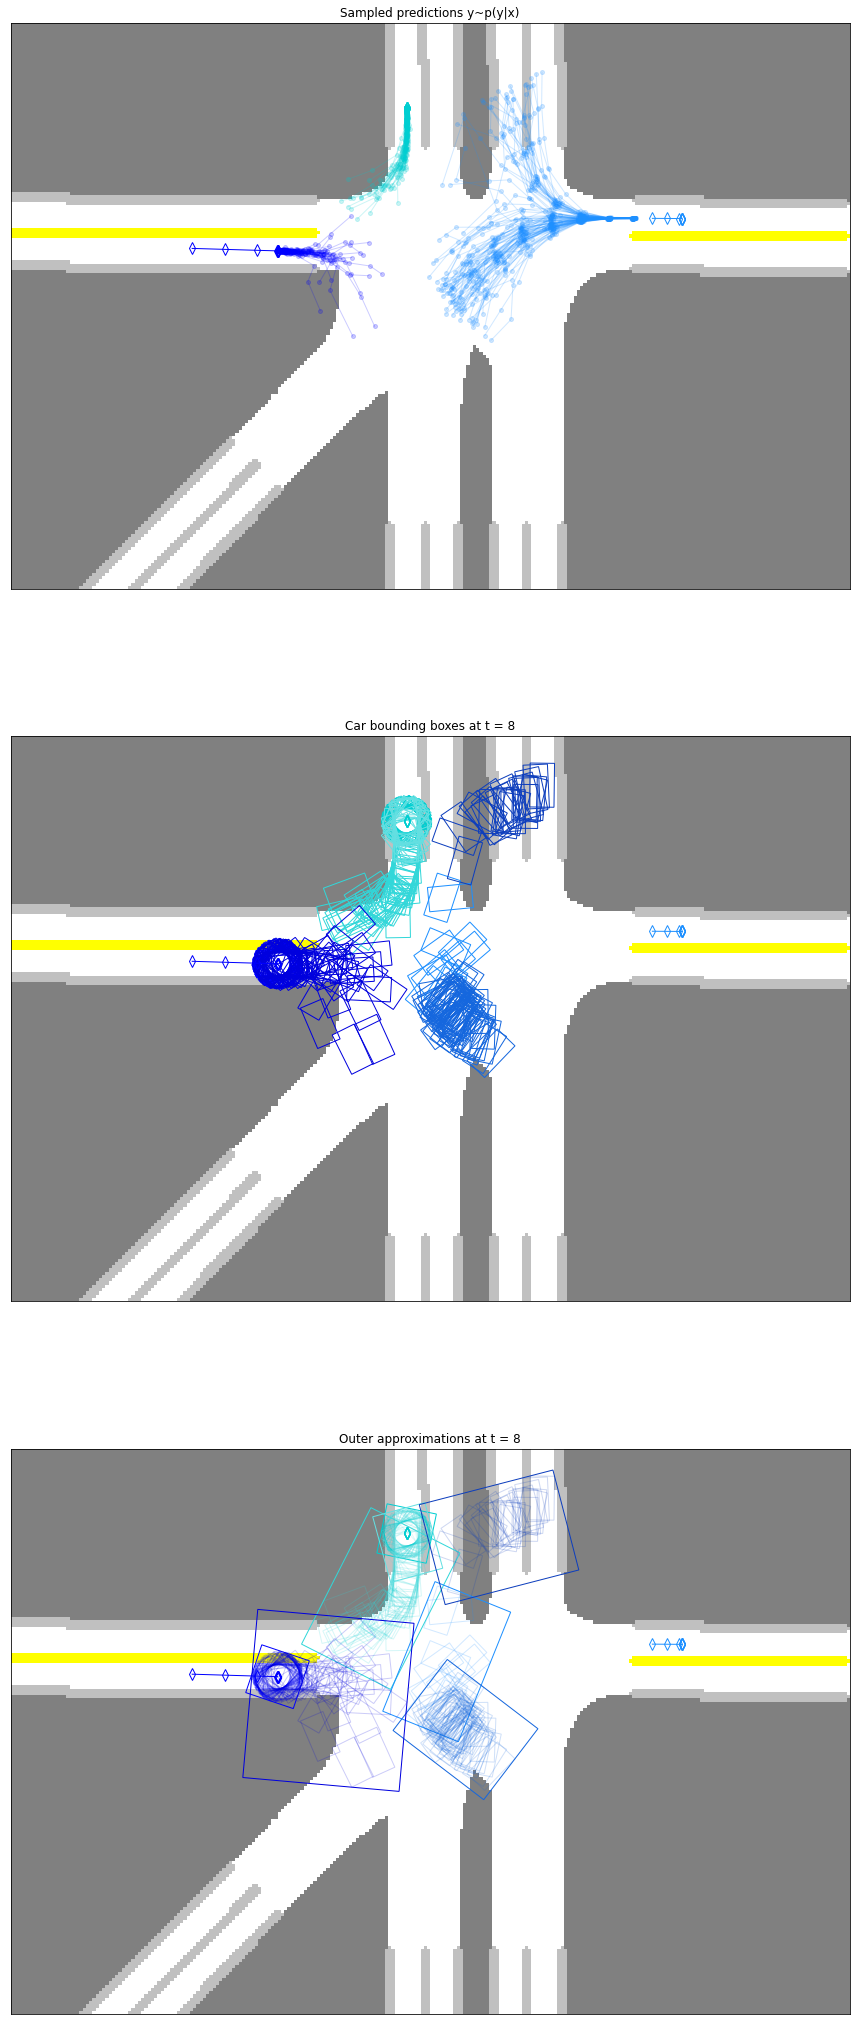

In [30]:
OVEHICLE_COLORS = [
    colors.LinearSegmentedColormap.from_list('bp', ['blue', 'blue'], N=8), #
    colors.LinearSegmentedColormap.from_list('ro', ['darkturquoise', 'paleturquoise'], N=8),
    colors.LinearSegmentedColormap.from_list('gy', ['green', 'yellow'], N=256),
    colors.LinearSegmentedColormap.from_list('ro', ['red', 'orange'], N=256),
    colors.LinearSegmentedColormap.from_list('bp', ['dodgerblue', 'darkblue'], N=8), #
    colors.LinearSegmentedColormap.from_list('gy', ['green', 'yellow'], N=256),
    colors.LinearSegmentedColormap.from_list('bp', ['blue', 'purple'], N=256),
    colors.LinearSegmentedColormap.from_list('ro', ['red', 'orange'], N=256),
    colors.LinearSegmentedColormap.from_list('gy', ['green', 'yellow'], N=256),
    colors.LinearSegmentedColormap.from_list('bp', ['blue', 'purple'], N=256),
    colors.LinearSegmentedColormap.from_list('ro', ['blue', 'darkblue'], N=8), #
    colors.LinearSegmentedColormap.from_list('gy', ['green', 'yellow'], N=256),
    colors.LinearSegmentedColormap.from_list('bp', ['blue', 'purple'], N=256),
    colors.LinearSegmentedColormap.from_list('ro', ['red', 'orange'], N=256),
    colors.LinearSegmentedColormap.from_list('gy', ['green', 'yellow'], N=256),
    colors.LinearSegmentedColormap.from_list('bp', ['blue', 'purple'], N=256),
]
ovehicle_colors = []
for ov_colormap in OVEHICLE_COLORS:
    ov_colors = ov_colormap(np.linspace(0,1,5))
    ovehicle_colors.append(ov_colors)

fig, axes = plt.subplots(3, 1, figsize=(12,30))
axes = axes.ravel()

for ax in axes:
    render_roads(ax, scene, is_white=True)

t = 7
# Plot other vehicles
# _ovehicles = [util.select(enumerate(ovehicles), 4)]
_ovehicles = util.select(enumerate(ovehicles), [1, 4, 10])
# _ovehicles = enumerate(ovehicles)
for ov_idx, ovehicle in _ovehicles:
    for ax in axes:
        ax.plot(ovehicle.past[:,0], ovehicle.past[:,1],
                marker='d', color=AGENT_COLORS[ov_idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    
    for ps in ovehicle.pred_positions:
        for p in ps:
            axes[0].plot(p[:,0], p[:,1],
                    marker='o', color=AGENT_COLORS[ov_idx % NCOLORS],
                    linewidth=1, alpha=0.2, markersize=4)
    
    for latent_idx in range(ovehicle.n_states):
        color = ovehicle_colors[ov_idx][latent_idx]

        # Plot overapproximation
        A = A_union[t][latent_idx][ov_idx]
        b = b_union[t][latent_idx][ov_idx]
        try:
            plot_h_polyhedron(axes[2], A, b, ec=color, alpha=1)
        except scipy.spatial.qhull.QhullError as e:
            print(f"Failed to plot polyhedron at timestep t={t}")
        
        # Plot vertices
        _vertex_set = vertices[t][latent_idx][ov_idx]
        for _vertices in _vertex_set:
            _vertices = _vertices.reshape(-1, 2)
            patch = patches.Polygon(_vertices, fill=False, color=color)
            axes[1].add_patch(patch)
            patch = patches.Polygon(_vertices, fill=False, alpha=0.2, color=color)
            axes[2].add_patch(patch)

axes[0].set_title("Sampled predictions y~p(y|x)")
axes[1].set_title("Car bounding boxes at t = 8")
axes[2].set_title("Outer approximations at t = 8")
for ax in axes:
    ax.set_aspect('equal')
    ax.set_facecolor("grey")

extent = np.array([0, scene.x_size, 0, scene.y_size])
should_zoom_in = True
if should_zoom_in:
    zoom = np.array([70, 70])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])

for ax in axes:
    ax.set_xlim([extent[0], extent[1]])
    ax.set_ylim([extent[2], extent[3]])
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

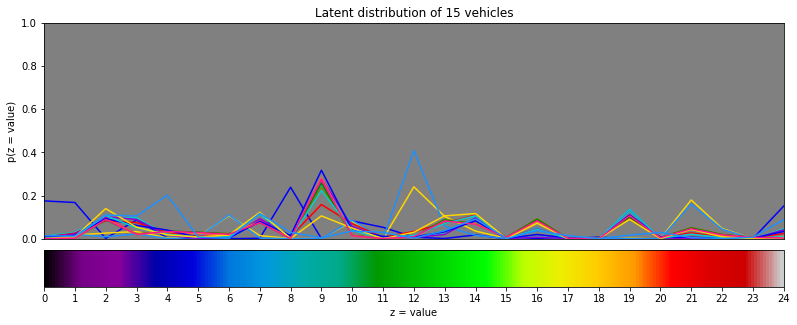

In [24]:
def generate_vehicle_latent_probs(
            z_mode=False, gmm_mode=False,
            full_dist=False, all_z_sep=False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)
    
    # model.latent is a DiscreteLatent
    # model.latent.p_dist is a tf.distribution.OneHotCategorical
    model.latent.p_dist = model.p_z_x(mode, x)
    # gets model.latent.p_dist.probs
    probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    return np.squeeze(probs, axis=1), nodes

probs, nodes = generate_vehicle_latent_probs(
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)
n_vehicles = len(nodes)

fig, ax1 = plt.subplots(figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, v_probs in enumerate(probs):
    ax1.plot(range(25), v_probs, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, 24])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, 25))
colorbar = plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

### Obtain the analytical PMF of p(y|x,z) given z ~ p(z|x)

Obtain the analytical PMF of p(y|x,z) given z ~ p(z|x) via GMM2D (inherits td.Distribution)

In [25]:
def generate_vehicle_gmms(
        eval_stg, scene, timesteps, ph, num_samples=100,
        z_mode=False, gmm_mode=False, full_dist=False, all_z_sep=False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                          mode,
                                                          most_likely_z=z_mode,
                                                          full_dist=full_dist,
                                                          all_z_sep=all_z_sep)
    
    dist, _ = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)
    
    return dist

def cholesky_mv_gaussian(pos, mu, L, is_log_prob=False):
    """Compute the discretized PDF of a multivariate Gaussian given its Cholesky decomposition.
    Parameters
    ==========
    pos : np.array
        The coordinate points of a multidmensional cartesian grid with shape (n_x,n_y,2)
        used to retrieve the discretized PDF at those points.
        For example the pos array from a 2D cartesian grid is:
        ```
        X = np.linspace(extent[0,0], extent[0,1], N)
        Y = np.linspace(extent[1,0], extent[1,1], N)
        X, Y = np.meshgrid(X, Y)
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y
        ```
    mu : np.array
        Mean of multivariate Gaussian.
    L : np.array
        Cholesky matrix of covariance matrix Sigma of multivariate Gaussian, namely Sigma = L L^T.
    
    Returns
    =======
    np.array
        The values of the PDF at the coordinate points with shape (n_x,n_y).
    """
    n = mu.size
    L_inv = np.linalg.inv(L)
    _p = -0.5*n*np.log(2*np.pi) - np.sum(np.log(np.diag(L)))
    _w = np.einsum("jk, ...k ->...j", L_inv, pos - mu)
    _w = -0.5*np.linalg.norm(_w, axis=-1)**2
    _p = _p + _w
    if is_log_prob:
        return _p
    else:
        return np.exp(_p)

def cholesky_mv_gaussian_mixture(pos, log_pis, mus, Ls):
    _p = np.zeros(pos.shape[:2])
    for (log_pi, mu, L) in zip(log_pis, mus, Ls):
        _w = cholesky_mv_gaussian(pos, mu, L, is_log_prob=True)
        _p += np.exp(log_pi + _w)
    return _p

## Plot Distributions

Plot GMM

In [26]:
dist = generate_vehicle_gmms(
        eval_stg, scene, timesteps, ph, num_samples=1,
        z_mode=False, gmm_mode=False,
        full_dist=True, all_z_sep=False)

if not hyp['dynamic']['VEHICLE']['distribution']:
    node_type = eval_stg.env.NodeType.VEHICLE
    dynamic = eval_stg.node_models_dict[node_type].dynamic
    dist = dynamic.integrate_distribution(dist)

# Log Mixing Proportions
# not used with this setting
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
covs = dist.get_covariance_matrix().cpu().detach().numpy()
Ls = dist.L.cpu().detach().numpy()

# assume that we are now using a mixture of Gaussians
# log_pis has shape (# vehicles, prediction_horizon, 2)
log_pis = log_pis[0,:,:]
# mus, sigmas has shape (# vehicles, prediction_horizon, 2)
mus = mus[0,:,:]
sigmas = sigmas[0,:,:]
# covs, Ls has shape (# vehicles, prediction_horizon, 2, 2)
covs = covs[0,:,:]
Ls = Ls[0,:,:]

In [27]:
node_type = eval_stg.env.NodeType.VEHICLE
dynamic = eval_stg.node_models_dict[node_type].dynamic
# dist = dynamic.integrate_distribution(dist)
dynamic

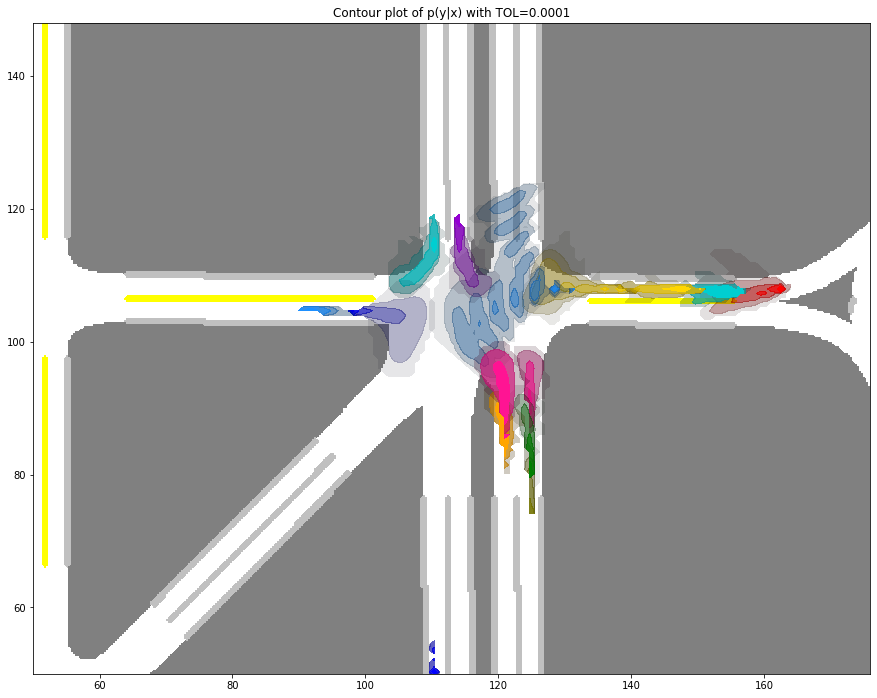

In [34]:
D = 3
extent = np.array([[0, scene.x_size], [0, scene.y_size]])
# min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
# max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
# extent = np.array([min_extent, max_extent]).T
TOL = 1e-4
N = 300
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))
render_roads(ax, scene, is_white=True)
extent = np.array([0, scene.x_size, 0, scene.y_size])

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
iter_vehicles = range(n_vehicles)
iter_ph = range(prediction_horizon)
for v_idx in iter_vehicles:
    Zs = []
    for p_idx in iter_ph:
        vp_log_pis = log_pis[v_idx,p_idx]
        vp_mus = mus[v_idx,p_idx]
        vp_Ls = Ls[v_idx,p_idx]
        Z = cholesky_mv_gaussian_mixture(pos, vp_log_pis, vp_mus, vp_Ls)
        Zs.append(Z)
    Z = np.max(Zs, axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, cmap=cmap, extent=extent, extend='max', locator=ticker.LogLocator())
    
ax.set_title(f"Contour plot of p(y|x) with TOL={TOL}")
ax.set_aspect('equal')
ax.set_facecolor("grey")

should_zoom_in = True
if should_zoom_in:
    zoom = np.array([50, 50])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])
    ax.set_xlim([extent[0], extent[1]])
    ax.set_ylim([extent[2], extent[3]])